# Configuración de hiperparámetros mediante búsqueda aleatoria (randomized-search)

En el *notebook* anterior, mostramos cómo usar un enfoque de **búsqueda grid-search** para buscar los mejores hiperparámetros que maximicen el rendimiento de generalización
de un modelo predictivo.

Sin embargo, un enfoque de búsqueda grid-search tiene limitaciones. No escala bien cuando el número de parámetros a ajustar aumenta. Además, el grid impone una regularidad durante la búsqueda que podría pasar por alto mejores valores de parámetros
entre dos valores consecutivos en el grid.

En este *notebook*, veremos un método diferente para ajustar hiperparámetros llamado
**búsqueda aleatatoria (randomized search)**.

## El modelo predictivo

Cargmos el conjunto de datos:

In [1]:
import pandas as pd

adult_census = pd.read_csv("adult_census.csv")

Extraemos la columna que contiene el objetivo (target).

In [2]:
target_name = "class"
target = adult_census[target_name]
target

,class
0,<=50K
1,<=50K
2,>50K
3,>50K
4,<=50K
...,...
48837,<=50K
48838,>50K
48839,<=50K
48840,<=50K


Eliminamos de nuestros datos la columna objetivo y la columna `"education-num"` que
duplica la información de la columna `"education"`.

In [3]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,id,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,2,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,3,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,4,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,5,18,?,103497,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


Una vez que el conjunto de datos está cargado, lo dividimos en conjuntos de entrenamiento y prueba.

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

Creamos el mismo *pipeline* predictivo que hicimos para la sección de búsqueda grid-search.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

## Configuración de hiperparámetros con randomized-search
Con el estimador GridSearchCV, los parámetros deben especificarse explícitamente. Ya mencionamos que explorar una gran cantidad de valores para diferentes parámetros rápidamente se vuelve inmanejable.

En su lugar, podemos generar los candidatos de parámetros al azar. De hecho, tal enfoque evita la regularidad del grid (cuadrícula). Por lo tanto, agregar más evaluaciones puede aumentar la resolución en cada dirección. Este es el caso en la situación frecuente donde la elección de algunos hiperparámetros no es muy importante, como en el caso del hiperparámetro 2 en la figura a continuación.





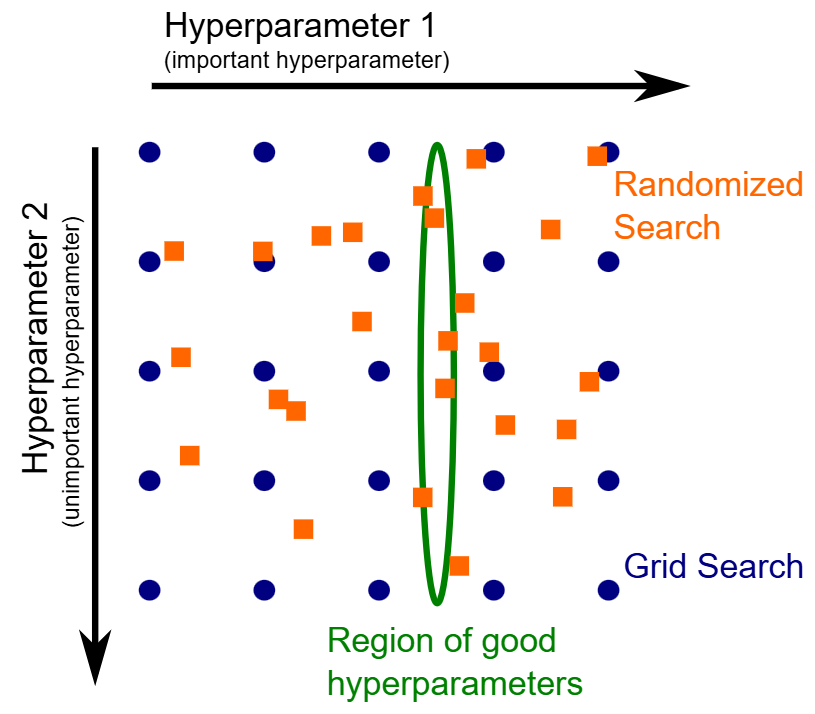

De hecho, el número de puntos de evaluación debe dividirse entre los dos hiperparámetros diferentes. Con un grid, el peligro es que la región de buenos hiperparámetros pueda caer entre las líneas de la cuadrícula. En la figura, dicha región está alineada con el grid dado que el hiperparámetro 2 tiene una influencia débil. Por el contrario, la búsqueda estocástica muestrea el hiperparámetro 1 independientemente del hiperparámetro 2 y encuentra la región óptima.

La clase `RandomizedSearchCV` permite dicha búsqueda estocástica. Se utiliza de manera similar a `GridSearchCV`, pero deben especificarse las distribuciones de muestreo en lugar de los valores de los parámetros. Por ejemplo, podemos extraer candidatos utilizando una distribución log-uniforme porque los parámetros que nos interesan toman valores positivos con una escala logarítmica natural (0.1 está tan cerca de 1 como 10 lo está).

Nota: Una búsqueda aleaatoria con `RandomizedSearchCV` es típicamente mejor en comparación con un grid-search (`GridSearchCV`) para optimizar 3 o más hiperparámetros.

Ahora, optimizaremos otros 3 parámetros además de los que optimizamos en el notebook anterior donde vimos `GridSearchCV`:

* `l2_regularization`: corresponde a la fuerza de la regularización;
* `min_samples_leaf`: corresponde al número mínimo de muestras requeridas en una hoja;
* `max_bins`: corresponde al número máximo de bins (contenedores) para construir los histogramas.

Recordemos el significado de los 2 parámetros restantes:

* `learning_rate`: corresponde a la velocidad a la que el gradient-boosting corrige los residuos en cada iteración de boosting;
* `max_leaf_nodes`: corresponde al número máximo de hojas para cada árbol en el ensamble.

Nota: `scipy.stats.loguniform` puede utilizarse para generar números flotantes. Para generar números aleatorios para los parámetros que requieren valores enteros (por ejemplo para `min_samples_leaf`) podemos usar una adaptación como se muestra en el siguiente código:

In [7]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

Ahora, podemos definir la búsqueda aleatoria utilizando las diferentes distribuciones.
Ejecutar 10 iteraciones de validación cruzada de 5 folds para parametrizaciones aleatorias de este modelo en este conjunto de datos puede tomar de 10 segundos a varios minutos, dependiendo de la velocidad de la computadora y el número de procesadores disponibles.

In [8]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "classifier__l2_regularization": loguniform(1e-6, 1e3),
    "classifier__learning_rate": loguniform(0.001, 10),
    "classifier__max_leaf_nodes": loguniform_int(2, 256),
    "classifier__min_samples_leaf": loguniform_int(1, 100),
    "classifier__max_bins": loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    verbose=1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 28.4 s, sys: 364 ms, total: 28.8 s
Wall time: 30.5 s


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              HistGradientBoostingC...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d0cc09278f0>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d0cbff1ba40>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x7d0cbff1bb30>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x7d0cbff1b3e0>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x7d0cbff1b920>},
                   verbose=1)

Luego, podemos calcular la puntuación de precisión (accuracy score) en el conjunto de prueba.

In [9]:
accuracy = model_random_search.score(data_test, target_test)
print(
    f"El accuracy de prueba del mejor modelo es de: {accuracy:.2f}"
)

El accuracy de prueba del mejor modelo es de: 0.88


Al igual que en la búsqueda grid-search, podemos inspeccionar los mejores parámetros encontrados.

In [10]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': np.float64(3.7219395573554825e-06),
 'classifier__learning_rate': np.float64(0.12070715239744786),
 'classifier__max_bins': np.int64(233),
 'classifier__max_leaf_nodes': np.int64(17),
 'classifier__min_samples_leaf': np.int64(27)}


También podemos inspeccionar los resultados usando el atributo `cv_results`.

In [11]:
# get the parameter names
column_results = [f"param_{name}" for name in param_distributions.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False
)


def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
8,0.000004,0.120707,17,27,233,0.869946,0.002554,1
2,3.339009,0.020756,59,27,142,0.865224,0.003417,2
7,19.728007,0.231694,9,2,6,0.833393,0.004641,3
6,155.531750,0.038848,37,16,6,0.829243,0.003424,4
3,0.000135,0.003871,27,93,4,0.758947,0.000013,5
0,0.020382,0.004885,2,5,28,0.758947,0.000013,5
4,0.280058,0.001289,4,5,23,0.758947,0.000013,5
9,0.000014,2.052863,214,77,7,0.734105,0.017561,8
1,15.641240,9.468494,11,1,6,0.669466,0.101920,9
5,785.550296,9.261874,19,7,3,0.664302,0.072910,10


Ten en cuenta que el ajuste está limitado por el número de combinaciones diferentes de parámetros que son puntuados por la búsqueda aleatoria. De hecho, podría haber otros conjuntos de parámetros que conduzcan a rendimientos de generalización similares o mejores, pero que no se probaron en la búsqueda. En la práctica, una búsqueda aleatoria de hiperparámetros generalmente se ejecuta con un gran número de iteraciones. Para evitar el costo computacional y aun así realizar un análisis decente, cargamos los resultados obtenidos de una búsqueda similar con 500 iteraciones.

In [12]:
# Nota: No ejecutar esta celda, este código solo está de referencia.
# Este código tarda mucho en ejecutarse (20 min o más). Yo lo he ejecutado por ti
# y he guardado los resultados en el archivo randomized_search_results.csv
# que te compartí.

#model_random_search = RandomizedSearchCV(
#         model, param_distributions=param_distributions, n_iter=500,
#     n_jobs=2, cv=5)
#model_random_search.fit(data_train, target_train)
#cv_results =  pd.DataFrame(model_random_search.cv_results_)
#cv_results.to_csv("randomized_search_results.csv")

In [14]:
cv_results = pd.read_csv("randomized_search_results.csv", index_col=0)

(
    cv_results[column_results]
    .rename(shorten_param, axis=1)
    .sort_values("mean_test_score", ascending=False)
)

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
483,0.024151,0.139102,35,9,148,0.869482,0.003286,1
233,11.584409,0.193531,10,4,210,0.869373,0.002873,2
329,0.016715,0.052058,104,6,202,0.868636,0.003289,3
499,0.554962,0.229862,37,24,224,0.868554,0.002765,4
371,0.000154,0.195902,49,15,182,0.868445,0.003031,5
...,...,...,...,...,...,...,...,...
269,0.001818,6.484369,2,74,8,0.283476,0.005123,494
71,0.000020,6.334299,2,1,106,0.283476,0.005123,494
99,1.918619,8.097050,2,51,7,0.283476,0.005123,494
54,0.056756,4.170488,3,36,24,0.283476,0.005123,494


En este caso, los modelos con mejor rendimiento tienen puntuaciones de prueba con una alta superposición (overlap) entre sí, lo que significa que, de hecho, el conjunto de parámetros que conduce al mejor rendimiento de generalización no es único.



## Resumen:
En este notebook, vimos cómo una búsqueda aleatoria ofrece una alternativa valiosa a la búsqueda grid-search (basada en cuadrícula) cuando el número de hiperparámetros a ajustar es mayor a dos. También vimos cómo la búsqueda aleatoria alivia la regularidad impuesta por la cuadrícula que podría ser problemática en algunos casos.

Más adelante, veremos cómo usar herramientas de trazado interactivas para explorar los resultados de grandes sesiones de búsqueda de hiperparámetros y obtener información sobre el rango de valores de parámetros que conducen a los modelos con mejor rendimiento y cómo los diferentes hiperparámetros están acoplados o no.

